# Randomly select splits to keep in the model

In [1]:
import torch
from sandbox import SimpleModel, toy_data, experiment_series, eval_series
from pathlib import Path

In [2]:
model_params = (1, 1, 8, 2, 2)

eps = 1e-4
num_kept_neurons = 2
lr=0.005
runs=10

#0: loss: 0.07180628925561905 - size: 209
#1: loss: 0.17834962904453278 - size: 209
#2: loss: 0.06091859191656113 - size: 209
#3: loss: 0.04270587116479874 - size: 209
#4: loss: 0.18945156037807465 - size: 209
#5: loss: 0.047206997871398926 - size: 209
#6: loss: 0.051094137132167816 - size: 209
#7: loss: 0.06979921460151672 - size: 209
#8: loss: 0.04269731044769287 - size: 209
#9: loss: 0.07925616949796677 - size: 209


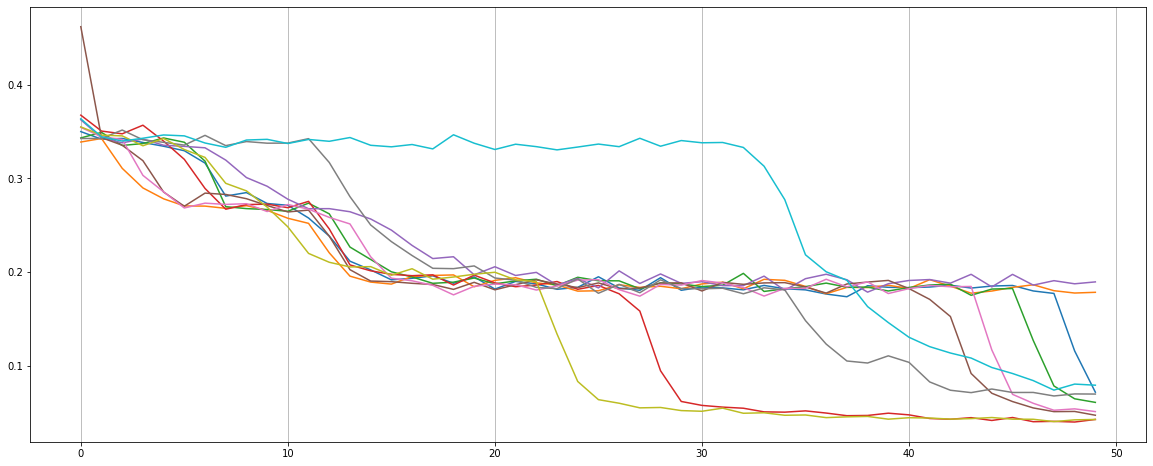

In [3]:
criterion = torch.nn.MSELoss()

def grow(model):
    new_neurons = model.grow(num_novel=4, eps_novel=eps, eps_split=eps)
    
    with model.direction_grad_only():
        optimizer = torch.optim.RMSprop(model.direction_params(), lr=1e-3, momentum=0.1, alpha=0.9)
        
        for _ in range(5):
            optimizer.zero_grad()
            model.update_grown_weight()
            train_x, train_y = toy_data()
            y = model(train_x)
            loss = criterion(y, train_y)
            
            penalty = 0
            for p in model.direction_params():
                penalty += (p ** 2).sum()
            
            loss.backward()
            penalty.backward()
            optimizer.step()
    
        model.update_grown_weight()
            

    selected = [torch.randperm(n)[:num_kept_neurons] for n in new_neurons]

    model.degrow(*selected)

series = experiment_series(model_params, runs=runs, grow=grow, lr=lr)

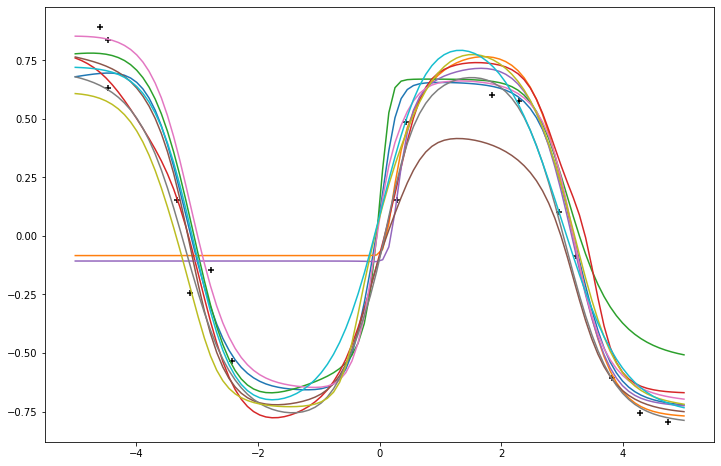

In [4]:
eval_series(series)

In [5]:
d = Path("results")
d.mkdir(parents=True, exist_ok=True)

torch.save(series, d / 'random_growth_tuned.pt')